# Examples 8.1

From Parameter Estimation and Inverse Problems, 3rd edition, 2018    
by R. Aster, B. Borchers, C. Thurber

## Implemented in Python by:
* Nima Nooshiri [@nimanzik](https://github.com/nimanzik)

---

In [1]:
%reset -f

## IMPORTS

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from peiplib.util import nextpow2, arange_nonint_step

In [3]:
plt.style.use('ggplot')
plt.style.use('./data/peiplib.mplstyle')

## SET UP THE BASIC PROBLEM PARAMETERS

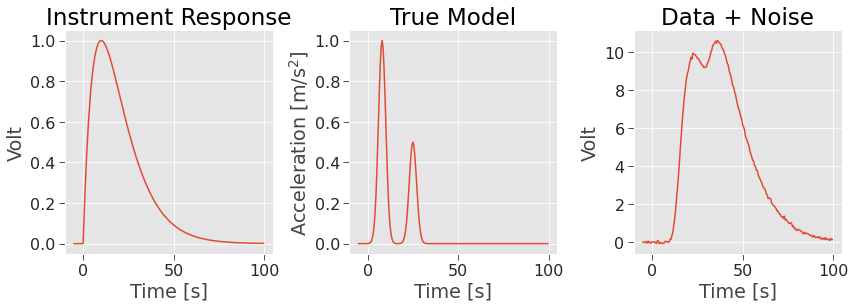

In [4]:
# Load pre-computed data

zipdata = np.load('./data/deconv.npz')
t = zipdata['t']
g = zipdata['g']
mtrue = zipdata['mtrue']

data_len = t.size - 1
deltat = t[1] - t[0]

# ----------
# Get the true (noise-free) and noisy data

noise = 0.05
d = np.convolve(g, mtrue, mode='full')
dn = d + noise * np.random.randn(d.size)

# ----------
# Plot the impulse response, true model and noisy data

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(w_pad=1.5)

ys = (g, mtrue, dn)
titles = ('Instrument Response', 'True Model', 'Data + Noise')
ylabels = ('Volt', 'Acceleration [m/s$^2$]', 'Volt')

for i_ax in range(len(axes)):
    ax = axes[i_ax]
    ax.plot(t[:-1], ys[i_ax][:data_len])
    ax.set(title=titles[i_ax], ylabel=ylabels[i_ax], xlabel='Time [s]')

## SPECTRA

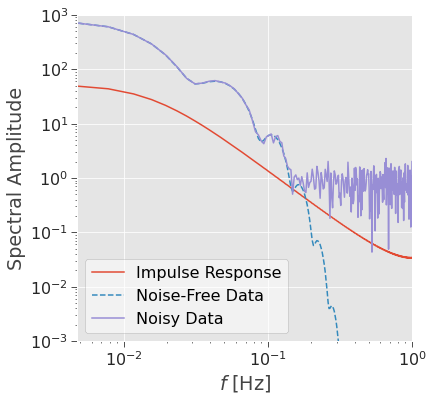

In [5]:
# Generate the spectra

n_trans = nextpow2(data_len * 1.5)
freqs = np.fft.rfftfreq(n_trans, d=deltat)

d_spec = np.fft.rfft(d, n=n_trans)
dn_spec = np.fft.rfft(dn, n=n_trans)
g_spec = np.fft.rfft(g, n=n_trans)

# ----------
# Plot the spectra for the impulse response, noise free and noisy data

fig, ax = plt.subplots()

ax.loglog(freqs, abs(g_spec), label='Impulse Response')
ax.loglog(freqs, abs(d_spec), '--', label='Noise-Free Data')
ax.loglog(freqs, abs(dn_spec), label='Noisy Data')

ax.set(
    xlabel=r'$f$ [Hz]', ylabel='Spectral Amplitude',
    xlim=[1.0 / data_len, 1.0], ylim=[1.0e-3, 1.0e+3])

ax.legend();

## SPECTRAL DIVISION

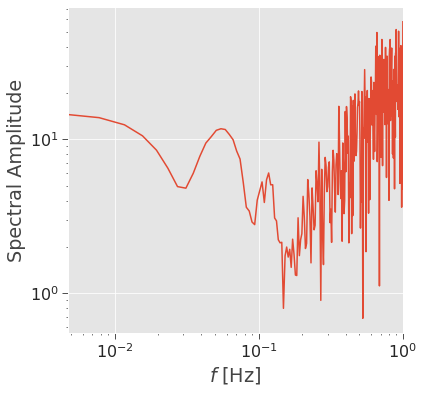

In [6]:
# Plot the spectra of the noisy data divided by the instrument

fig, ax = plt.subplots()
ax.loglog(freqs, abs(dn_spec / g_spec))
ax.set(
    xlabel=r'$f$ [Hz]', ylabel='Spectral Amplitude',
    xlim=[1.0 / data_len, 1.0]);

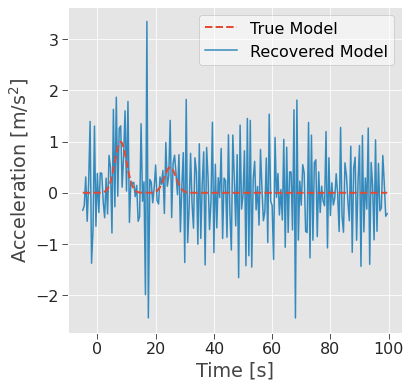

In [7]:
# Do the inverse convolution

mperf = np.fft.irfft(d_spec / g_spec, n=n_trans)
mn = np.fft.irfft(dn_spec / g_spec, n=n_trans)

# ----------
# Plot recovered model from spectral division

fig, ax = plt.subplots()

ax.plot(t[:data_len], mperf[:data_len], '--', label='True Model', lw=2)
ax.plot(t[:data_len], mn[:data_len], label='Recovered Model', zorder=1)

ax.set(xlabel='Time [s]', ylabel='Acceleration [m/s$^2$]')
ax.legend();

## WATER-LEVEL REGULARISATION

In [8]:
# Water-level values
samples, n_wlevels = arange_nonint_step(-1.0, 2.0, 0.1, retnum=True)
water_levels = 10**samples

# Allocate arrays to store necessary information
mstore = np.empty((n_wlevels, n_trans))
mnorms = np.empty(n_wlevels)
resids = np.empty(n_wlevels)

for i_wlevel, wlevel in enumerate(water_levels):

    # Apply water-level damping
    gw_spec = np.empty_like(g_spec)
    abs_gspec = np.absolute(g_spec)
    
    idx1 = abs_gspec > wlevel
    gw_spec[idx1] = g_spec[idx1]
    
    idx2 = ((abs_gspec > 0.0) & (abs_gspec <= wlevel))
    gw_spec[idx2] = wlevel * (g_spec[idx2] / abs_gspec[idx2])
    
    idx3 = abs_gspec == 0.0
    gw_spec[idx3] = wlevel
    
    # Get the temporal model and store the necessary information
    mw = np.fft.irfft(dn_spec / gw_spec, n=n_trans)
    mstore[i_wlevel] = mw
    
    mnorms[i_wlevel] = np.linalg.norm(mw, 2)
    
    a = ((dn_spec / gw_spec) * g_spec) - dn_spec
    resids[i_wlevel] = np.linalg.norm(np.fft.irfft(a, n=n_trans))

## WATER-LEVEL L-CURVE

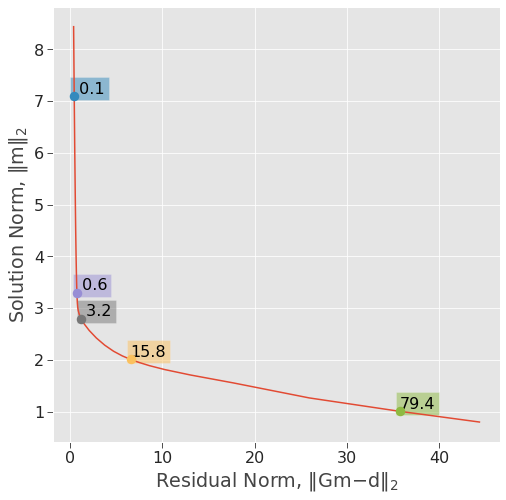

In [9]:
# Plot the L-curve with respect to water level regularization

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(resids, mnorms)
ax.set(
    xlabel='Residual Norm, $\Vert$Gm$\minus$d$\Vert_2$',
    ylabel='Solution Norm, $\Vert$m$\Vert_2$')

for i_wlevel in range(1, n_wlevels, 7):
    x, y = resids[i_wlevel], mnorms[i_wlevel]
    p = ax.plot(x, y, 'o')[0]
    ax.text(
        x, y, f'{water_levels[i_wlevel]:4.1f}', va='bottom', ha='left',
        zorder=1, bbox=dict(facecolor=p.get_color(), alpha=0.5))

## RECOVERED MODELS

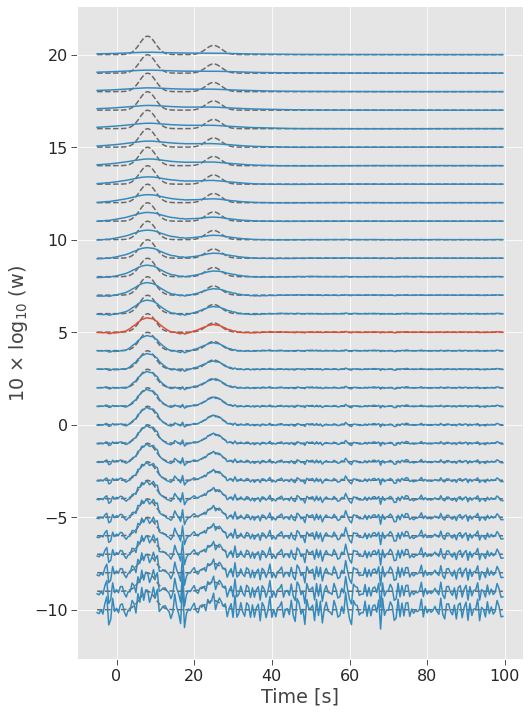

In [10]:
fig, ax = plt.subplots(figsize=(8, 12))

# Plot suite of models recovered and highlight the selected solution
i_select = 15

for i_wlevel in range(n_wlevels):
    offset = 10 * np.log10(water_levels[i_wlevel])
    ax.plot(t[:data_len], mperf[:data_len] + offset, '--', color='dimgray')

    color = '#348abd' if i_wlevel != i_select else '#e24a33'
    ax.plot(t[:data_len], mstore[i_wlevel, :data_len] + offset, c=color)

ax.set(xlabel='Time [s]', ylabel='10 $\\times$ log$_{10}$ (w)');

## DESIRED REGULARISED MODEL

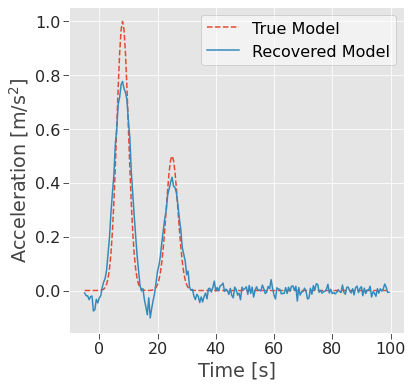

In [11]:
fig, ax = plt.subplots()

ys = (mtrue, mstore[i_select])
linestyles = ('--', '-')
labels = ('True Model', 'Recovered Model')

for i in range(2):
    ax.plot(t[:data_len], ys[i][:data_len], label=labels[i], ls=linestyles[i])

ax.set(xlabel='Time [s]', ylabel='Acceleration [m/s$^2$]')
ax.legend();